<a href="https://colab.research.google.com/github/JAntonioRosales/CE888-Data-Science/blob/main/project/code/song_likeability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Song Likeability (Spotify Dataset)

## 1 - Description

This dataset contains 2017 samples (songs) for which different sound attributes were collected using Spotify's API. For each song, there are 13 attributes, the song's title, artist, and a label for liked (1) or disliked (0).

Spotify's API provides the following attributes:

1. **Acousticness** *(float: 0.0 to 1.0)*

  A confidence measure whether the track is acoustic. 1 is high confidence the song is acoustic.
  
2. **Danceability** *(float: 0.0 to 1.0)*

  How suitable a track is for dancing based on elements like tempo, rhythm and overall regularity. 1 is most danceable.

3. **Duration_ms** *(int)*

  Duration of the song in milliseconds.

4. **Energy** *(float: 0.0 to 1.0)*

  Perceptual measure of intensity and activity. 1 is most energetic, making a song feel fast, loud, and noisy.

5. **Instrumentalness** *(float: 0.0 to 1.0)*

  Predicts whether a track contains no vocals. 1 is high confidence that a song is instrumental, where "ooh" and "aah" sounds are considered instrumental.

6. **Key** *(int: -1 to 11)*

  The key the song is in. Integers map to pitches using standard Pitch Class notation: C = 0, C#/Db = 1, D = 2, etc. When no key is detected the value is -1.

7. **Liveness** *(float: 0.0 to 0.1)*

  Detects the presence of an audience on the song. Higher values represent a high probability the track was recorded live.

8. **Loudness** *(float: -60 to 0)*

  The overall loudness of a song measured in decibels (dB).

9. **Mode** *(int: 1 or 0)*

  The modality of a track. Major == 1 and minor == 0.

10. **Speechiness** *(float: 0.0 to 1.0)*

  Detects the presence of spoken words in a song. The closer the value to 1, the higher probability the track is made entirely of spoken words.

11. **Tempo** *(float)*

  Overall estimated tempo of a song in beats per minute (BPM).

12. **Time_signature** *(int: 3 to 7)*

  Estimated time signature, which specifies how many beats are in each bar (measure). A value of 3 indicates a time signature of 3/4, and 7 indicates one of 7/4.

13. **Valence** *(float: 0.0 to 1.0)*

  Describes the musical positiveness conveyed by a song. Low valence indicates more negative feelings, and high valence indicates positiveness.

*These descriptions were retrieved from Spotify's webpage:
https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features.*

The way the dataset was constructed allows for the discovery of which **sound attributes** make a song appealing to the listener. As written by its creator, it was used to build a classifier that could predict whether or not he would like a song.

The dataset was created by George McIntire and can be found on Kaggle along with his original article at: https://www.kaggle.com/geomack/spotifyclassification.

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
# Function for surrogate creation
def create_surrogate(majority, minority, imb):
  
  # Subsampling
  no_min_samples = int(majority.shape[0] * ((1/imb) - 1))
  min_indices = np.random.choice(range(minority.shape[0]), size=no_min_samples, replace=False) # Make sure we don't get the same sample more than once
  min_samples = minority.iloc[min_indices]
  
  # Surrogate dataset
  return pd.concat([majority, min_samples])

## 2 - Data exploration and visualization

In [3]:
# Loading and visualizing the data
songs = pd.read_csv('https://raw.githubusercontent.com/JAntonioRosales/CE888-Data-Science/main/project/datasets/song_likeability.csv')
songs

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,2012,0.00106,0.584,274404,0.932,0.002690,1,0.1290,-3.501,1,0.3330,74.976,4.0,0.211,0,Like A Bitch - Kill The Noise Remix,Kill The Noise
2013,2013,0.08770,0.894,182182,0.892,0.001670,1,0.0528,-2.663,1,0.1310,110.041,4.0,0.867,0,Candy,Dillon Francis
2014,2014,0.00857,0.637,207200,0.935,0.003990,0,0.2140,-2.467,1,0.1070,150.082,4.0,0.470,0,Habit - Dack Janiels & Wenzday Remix,Rain Man
2015,2015,0.00164,0.557,185600,0.992,0.677000,1,0.0913,-2.735,1,0.1330,150.011,4.0,0.623,0,First Contact,Twin Moons


The first thing we can see is that the first column ('Unnamed: 0') is the data's index. However, Pandas automatically assigns an index, so we can drop that column.

In [4]:
# Dropping additional indexing column
songs = songs.drop(columns=['Unnamed: 0'])
songs.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


We now print information about the data to see what we are dealing with.

In [5]:
# Printing dataset info
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2017 non-null   float64
 1   danceability      2017 non-null   float64
 2   duration_ms       2017 non-null   int64  
 3   energy            2017 non-null   float64
 4   instrumentalness  2017 non-null   float64
 5   key               2017 non-null   int64  
 6   liveness          2017 non-null   float64
 7   loudness          2017 non-null   float64
 8   mode              2017 non-null   int64  
 9   speechiness       2017 non-null   float64
 10  tempo             2017 non-null   float64
 11  time_signature    2017 non-null   float64
 12  valence           2017 non-null   float64
 13  target            2017 non-null   int64  
 14  song_title        2017 non-null   object 
 15  artist            2017 non-null   object 
dtypes: float64(10), int64(4), object(2)
memory

In [6]:
# Counting missing values
songs.isnull().sum().sum()

0

We have 2017 samples (songs), 15 features, and one target. There are no missing values.

The first 13 features are different musical attributes (e.g. acousticness, song duration, and tempo) that are recorded **numerically**, while the last two are **categorical** features referring to the song's title and artist.

We will analyze the number of different song titles and artists to figure out what to do with those features.

In [7]:
# Different values for 'song_title'
songs['song_title'].value_counts()

River                 3
Jack                  3
Mask Off              2
Be My Baby            2
Oblivion              2
                     ..
L'Amour Parfait       1
I Follow Rivers       1
From Nowhere          1
I Need You            1
I Wanna Get Better    1
Name: song_title, Length: 1956, dtype: int64

In [8]:
# Percentage of repeated song titles
diff_titles = len(songs['song_title'].value_counts())
samples = songs.shape[0]
print('Repeated titles:', 100*(1-(diff_titles/samples)), '%')

Repeated titles: 3.024293505205755 %


In [9]:
# Different values for 'artist'
songs['artist'].value_counts()

Drake                16
Rick Ross            13
Disclosure           12
WALK THE MOON        10
Backstreet Boys      10
                     ..
Real Connoisseur      1
Deep Purple           1
Brenton Wood          1
Ultimate Painting     1
Bleachers             1
Name: artist, Length: 1343, dtype: int64

In [10]:
# Percentage of repeated artists
diff_artist = len(songs['artist'].value_counts())
print('Repeated artists:', 100*(1-(diff_artist/samples)), '%')

Repeated artists: 33.41596430342092 %


It is rather difficult to have two songs with the same **title**, and we can see that from the dataset, for only 3% of the titles are repeated at leat once. It would be fairly complicated to draw useful information from them; besides, what we are interested in is knowing *the characteristics of sound that are appealing to the listener*... So we will drop this feature.

On the other hand, some **artists** repeat themselves at least once in 1/3 of the samples. This could definitely be helpful to determine the listener's favorite (or least favorite) artists. But again, the focus is learning the *sound attributes that make a song likeable*, so we will drop this feature as well.

*(Besides, the model would have to be trained with 1343 unique values for artists, requiring much more computation; and in the case of predicting a song from a different artist than those the model trained with, the algorithm could be less effective if, in fact, there was a relationship between artist and song likeability)*

In [11]:
# Dropping both categorical features
songs = songs.drop(columns=['song_title', 'artist'])
songs.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1


Our final data has the following shape:

In [12]:
# Final shape of data
songs.shape

(2017, 14)

2017 songs, 13 features, and 1 label.

We print information for the numerical features and plot their histograms to better visualise and understand the data.

In [13]:
# Info for numerical features
songs.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


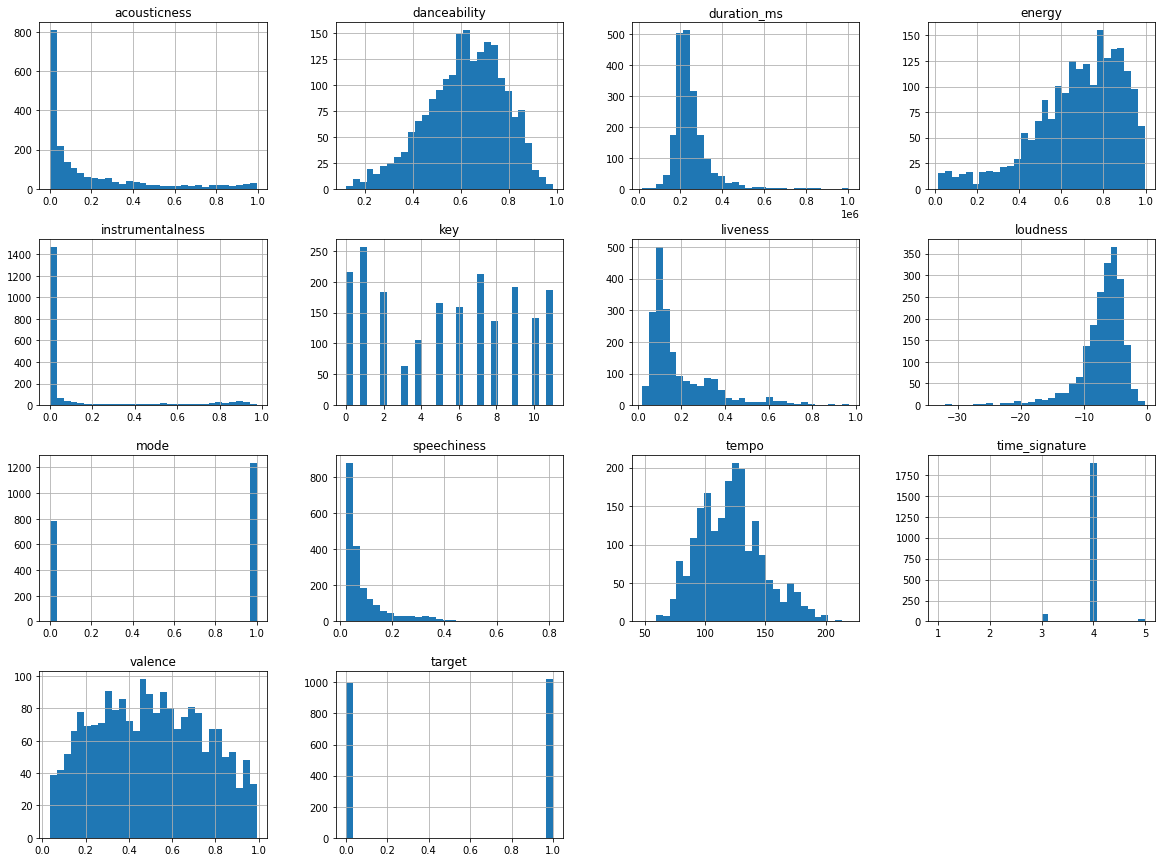

In [14]:
# Plotting numerical features
blob = songs.hist(bins=30, figsize=(20, 15))
plt.savefig('song_complete_hist.pdf', dpi=1200, bbox_inches='tight')

We can observe that...

1. Seven features have **continuous** values that range from **0 to 1**.

  *Acousticness*, *instrumentalness*, *liveness*, and *speechiness* are skewed towards low values, indicating that the majority of the songs in the dataset are:

*   Likely not acoustic.
*   Likely to have voices and not be instrumental music.
*   Probably recorded in a studio and not live.
*   Very likely to actually be music and not a podcast.

  *Danceability* and *valence* resemble a normal distribution, while *energy* is skewed towards high values, indicating that many songs in the dataset feel fast/energetic.

2. *Tempo*, *loudness*, and *duration* are also **continuous** values, but they are recorded in **different ranges** according to their measurement units (BPM, dB, and ms, respectively).

3. *Mode*, *key*, and *time signature* all have **discrete** values, matching their description in section 1. Mode is binary (major or minor), key is one of the 12 pitch values, and time signature is either 3/4, 4/4 (this being the vast majority of the songs) or 5/4.

As of right now, the features need not be scaled because our baseline model, **Random Forest**, does not take into account any sort of *distance*.

However, when clustering using K-Means, we will have to scale the data to not throw the learner off with varying ranges.

Before moving on to splitting our data and creating the 3 imbalanced surrogate datasets, we will focus on the **target** label.

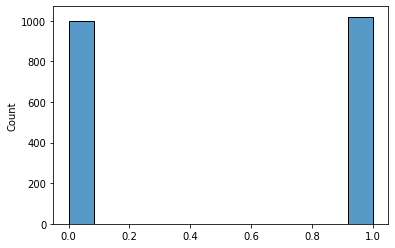

In [15]:
# Plotting 'target' histogram to analyze its balance
blob = sns.histplot(songs['target'].values)

We confirm that it is a binary variable that is either 0 (disliked song) or 1 (liked song), and that it is originally balanced.

In [16]:
# Calculating the imbalance of the dataset
value, count = np.unique(songs['target'].values, return_counts=True)
print('Disliked:', (count[0]*100/(count[0]+count[1])), '%')
print('Liked:', (count[1]*100/(count[0]+count[1])), '%')

Disliked: 49.42984630639564 %
Liked: 50.57015369360436 %


But when we observe the distribution of zeroes and ones in the set...

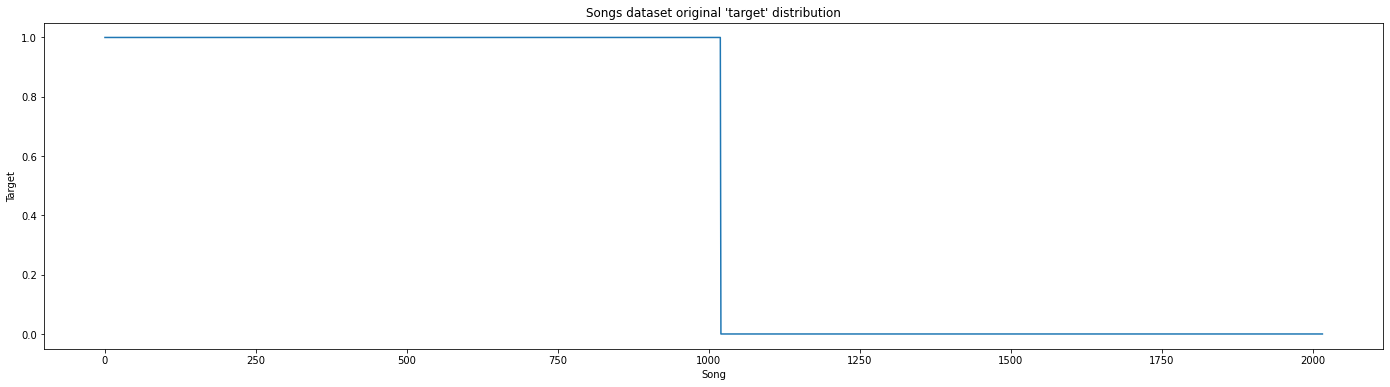

In [17]:
#target0 = np.array(songs.index[songs['target']==0])
#target1 = np.array(songs.index[songs['target']==1])

# Plotting the distribution of 0s and 1s
plt.figure(figsize=(24,6))
sns.lineplot(data=songs['target'])
plt.title("Songs dataset original 'target' distribution")
plt.xlabel('Song')
plt.ylabel('Target')
plt.savefig('song_target_dist.pdf', dpi=1200, bbox_inches='tight')

We can see that the first half is exclusively liked songs and the second half is only disliked ones. We will need to shuffle the set when splitting! 

## 3 - Surrogates and splitting

Now it is time to create three imbalanced datasets from the original one.

We will assume our listener has a very specific taste in music and he rarely likes a new song. We will keep the same number of disliked songs as in the original dataset, but we will vary the number of liked ones making them the minority.

In [18]:
# Dividing the dataset into liked and disliked songs
liked = songs.loc[songs['target']==1]
disliked = songs.loc[songs['target']==0]

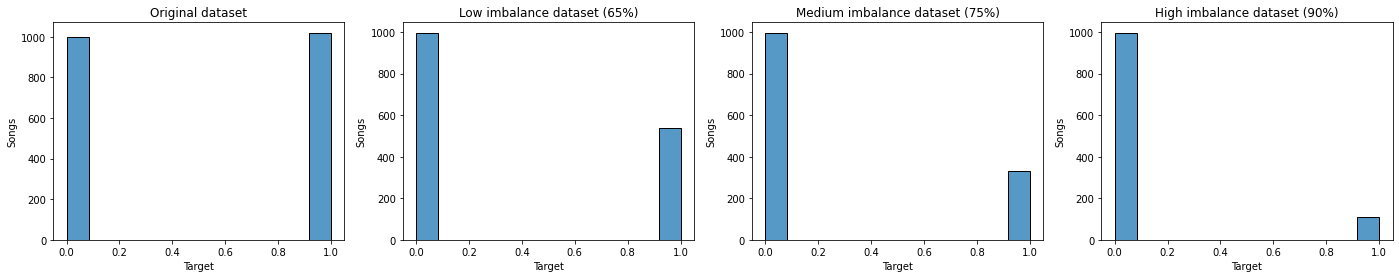

In [19]:
# Creating surrogate datasets
songs_li = create_surrogate(disliked, liked, 0.65) # Low imbalance
songs_mi = create_surrogate(disliked, liked, 0.75) # Medium imbalance
songs_hi = create_surrogate(disliked, liked, 0.90) # High imbalance

# Plotting the different datasets
plt.figure(figsize=(24,4))

for plot in range(1,5):
  plt.subplot(1,4,plot)
  plt.xlabel('Target')
  plt.ylabel('Songs')
  
  # Original set
  if plot == 1:
    sns.histplot(songs['target'].values)
    plt.title('Original dataset')
  
  # Low imbalance dataset
  elif plot == 2:
    sns.histplot(songs_li['target'].values)
    plt.title('Low imbalance dataset (65%)')
  
  # Medium imbalance dataset
  elif plot == 3:
    sns.histplot(songs_mi['target'].values)
    plt.title('Medium imbalance dataset (75%)')
  
  # High imbalance dataset
  else:
    sns.histplot(songs_hi['target'].values)
    plt.title('High imbalance dataset (90%)')

plt.savefig('song_surrogates.pdf', dpi=1200, bbox_inches='tight')
plt.show()

In [20]:
# Confirming the imbalances are correct
value_li, count_li = np.unique(songs_li['target'].values, return_counts=True)
value_mi, count_mi = np.unique(songs_mi['target'].values, return_counts=True)
value_hi, count_hi = np.unique(songs_hi['target'].values, return_counts=True)
counts = [count_li, count_mi, count_hi]

for surr in range(3):
  print('Surrogate', surr + 1)
  print('Disliked:', (counts[surr][0]*100/(counts[surr][0]+counts[surr][1])), '%')
  print('Liked:', (counts[surr][1]*100/(counts[surr][0]+counts[surr][1])), '%\n')

Surrogate 1
Disliked: 65.03587736464449 %
Liked: 34.964122635355515 %

Surrogate 2
Disliked: 75.01881113619262 %
Liked: 24.981188863807375 %

Surrogate 3
Disliked: 90.06323396567299 %
Liked: 9.93676603432701 %



The imbalanced surrogates were created correctly, so the final step is splitting each dataset into testing and training.

In [21]:
# Separating training and testing sets with stratification
songs_train, songs_test = train_test_split(songs, test_size=0.2, random_state=18, shuffle=True, stratify=songs['target'].values)
songs_li_train, songs_li_test = train_test_split(songs_li, test_size=0.2, random_state=18, shuffle=True, stratify=songs_li['target'].values)
songs_mi_train, songs_mi_test = train_test_split(songs_mi, test_size=0.2, random_state=18, shuffle=True, stratify=songs_mi['target'].values)
songs_hi_train, songs_hi_test = train_test_split(songs_hi, test_size=0.2, random_state=18, shuffle=True, stratify=songs_hi['target'].values)

And we can verify that, in fact, the samples were shuffled.

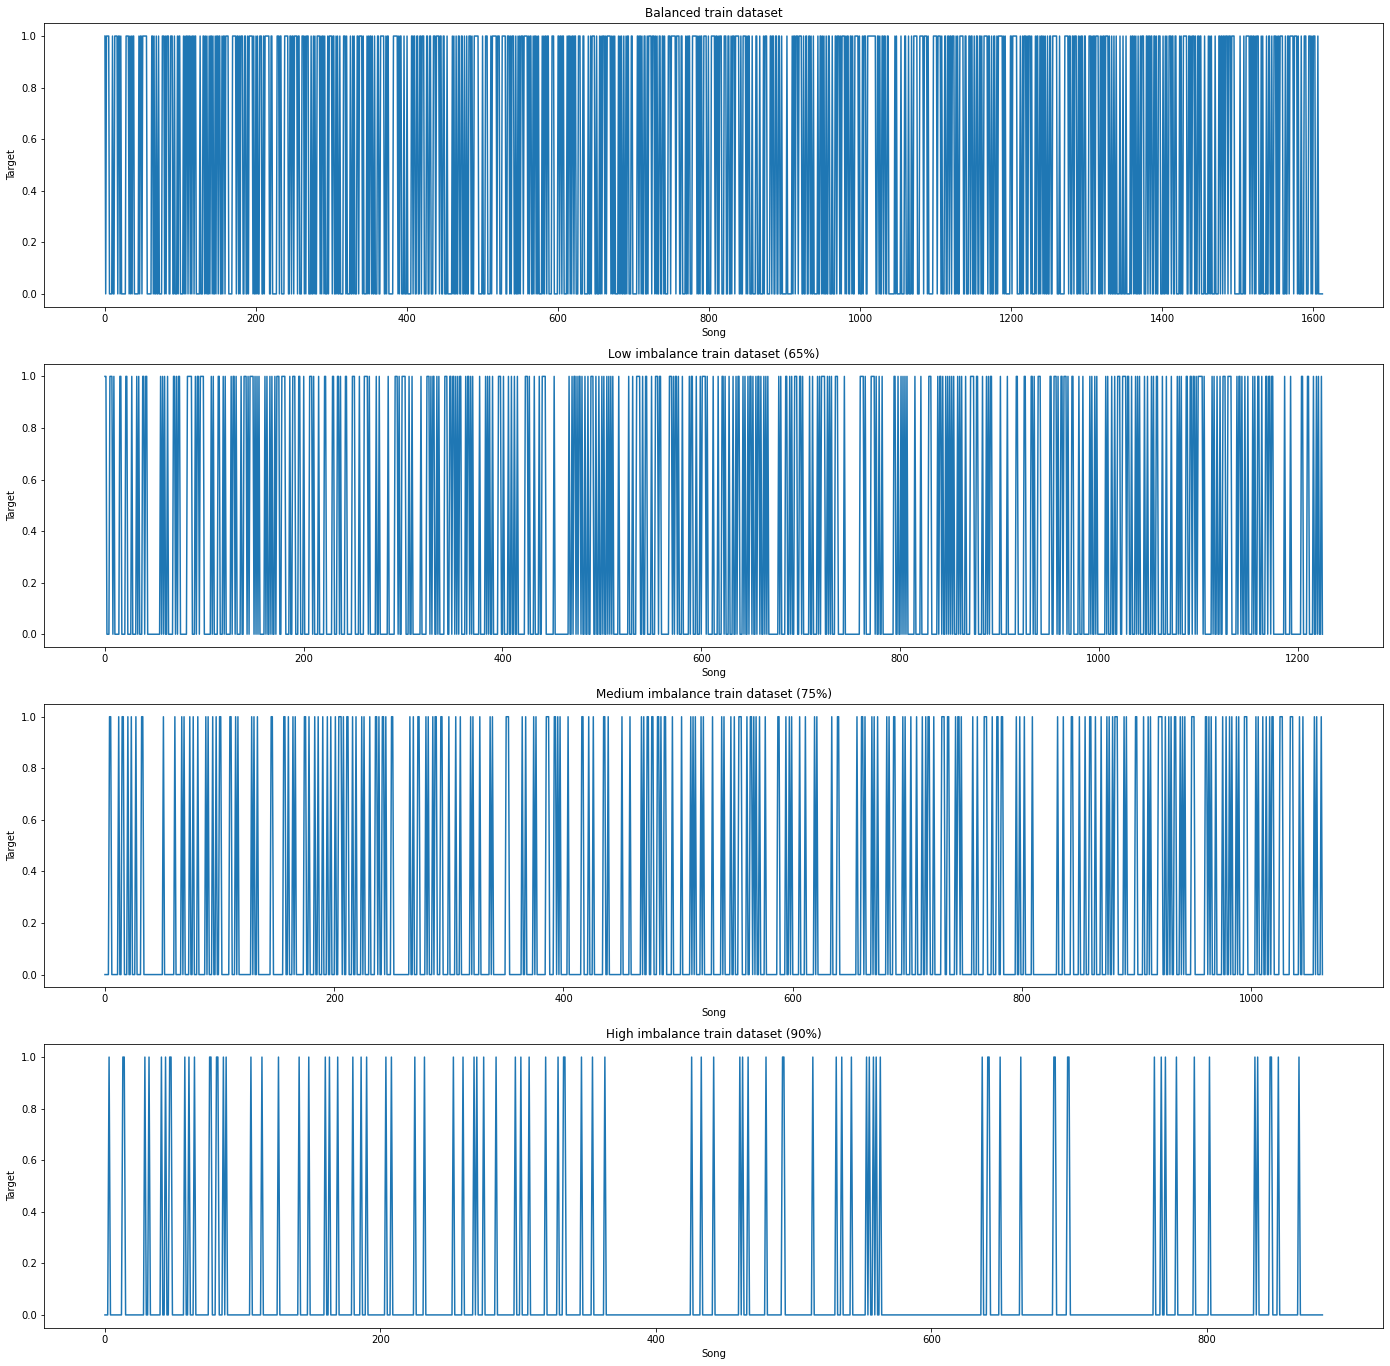

In [22]:
# Plotting the different datasets' distribution of 0s and 1s
plt.figure(figsize=(24,24))

# Balanced set
plt.subplot(4,1,1)
indexed_set = songs_train.set_index(pd.Series(np.arange(songs_train.shape[0]))) # Indexes the new shuffled dataset in ascending order to show the plots correctly
sns.lineplot(data=indexed_set['target'])                                        # otherwise, the plot would sort with the original indexes, showing the same half & half split 
plt.title('Balanced train dataset')
plt.xlabel('Song')
plt.ylabel('Target')

# Low imbalance dataset
plt.subplot(4,1,2)
indexed_set = songs_li_train.set_index(pd.Series(np.arange(songs_li_train.shape[0])))
sns.lineplot(data=indexed_set['target'])
plt.title('Low imbalance train dataset (65%)')
plt.xlabel('Song')
plt.ylabel('Target')

# Medium imbalance dataset
plt.subplot(4,1,3)
indexed_set = songs_mi_train.set_index(pd.Series(np.arange(songs_mi_train.shape[0])))
sns.lineplot(data=indexed_set['target'])
plt.title('Medium imbalance train dataset (75%)')
plt.xlabel('Song')
plt.ylabel('Target')

# High imbalance dataset
plt.subplot(4,1,4)
indexed_set = songs_hi_train.set_index(pd.Series(np.arange(songs_hi_train.shape[0])))
sns.lineplot(data=indexed_set['target'])
plt.title('High imbalance train dataset (90%)')
plt.xlabel('Song')
plt.ylabel('Target')

plt.savefig('song_surrogates_dist.pdf', dpi=1200, bbox_inches='tight')
plt.show()

We can see that the sets were shuffled when split, mixing 0s and 1s, and we can also appreciate how the total number of disliked songs decreases for each surrogate as the imbalance increases. This is because we kept the original number of liked songs and reduced the number of disliked songs to attain the desired imbalance.